In [1]:
import numpy as np
import time
# np.seterr(all='raise')
np.seterr(under='ignore', invalid='raise', divide='raise', over='raise')
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v BESSEL FUNCTIONS
from scipy.special import zeta, polygamma, factorial
import matplotlib as mpl
from mpmath import zeta
from itertools import cycle
from scipy.special import kve


from functions import *
from xsec_expressions import *


mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})

In [2]:
path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]
def gstar_interp(T):
    return np.interp(T, T_data, g_eff)

#####
# CONSTANTS
#######
# ----------------------------
# Constant values
# ----------------------------
GSTAR = 90.0
GSTAR_S = 90.0
ME = 0.000511e-3  # GeV
ALPHA_EM = 1.0/137.0
MPL   = 1.2209e19      # GeV
INCLUDE_HS_IN_H = True

# --- unit conversions: cm^3/s -> GeV^-2 ---
cm_to_GeV_inv = 5.0677307e13
s_to_GeV_inv  = 1.5192674e24
cm3s_to_GeV2  = (cm_to_GeV_inv**3) / s_to_GeV_inv
Gev2_to_cm3s = 1.0 / cm3s_to_GeV2

In [3]:
# ----------------------------
# Set up the system
# ----------------------------

alpha = 4.18e-5 #10
epsilon =  3e-10
mchi = 10 # 0.3
mA = 8 # 0.3*0.7

gchi = 2
gA = 3

sv_xxAA = sigma_xx_to_AA(alpha, mchi, mA) #GeV^-2
sv_xxee = sigmav_chichi_ee(epsilon, alpha, mchi, mA)
gamma = gammaA_ee(epsilon, mA) #GeV

print(sv_xxAA * Gev2_to_cm3s)
print("xx -> SM xsec:")
print(sv_xxee * Gev2_to_cm3s)
params = {
    "mchi": mchi,
    "mA":   mA,
    "alphaD": alpha,
    "epsilon": epsilon,
    "sv_xxee": sv_xxee,
    "sv_xxAA": sv_xxAA,
    #"sv_AAxx": sv_AAxx,
    #"sv_xxff": sv_xxff,
    "t_dep": True, #T-dependent gstar
    "gamma_Aee": gamma,
    "gchi": gchi,
    "gA": gA}

# start in rel. regime, want to include all time where production may be relevant
x_i, x_f = 0.1, 1000.0
T_i = mchi / x_i

Th_i = 1e-4* T_i  # start very cold
nchi_i = 1e-10
nA_i  = 1e-10

# nchi_i = 0.0001
# nA_i   = 0.0001
# Th_i = T_i * 1e-2

y0 = np.array([nchi_i, nA_i, Th_i])  # initial conditions: n_chi, n_A, Th, H, C_chi, C_A
xs  = np.geomspace(x_i, x_f, 1000)


2.993174219265496e-28
xx -> SM xsec:
1.4271944841269988e-44


In [36]:
start = time.time()
result = evolve(params, x_i, x_f, y0, xs, log_space = True)

end = time.time()
print("Time taken: ", end - start, " seconds")

nchi_evolve, nA_evolve, Th_evolve = result["sol"]
x_evolve = result["x_arr"]
T_evolve = mchi / x_evolve

Time taken:  22.777941942214966  seconds


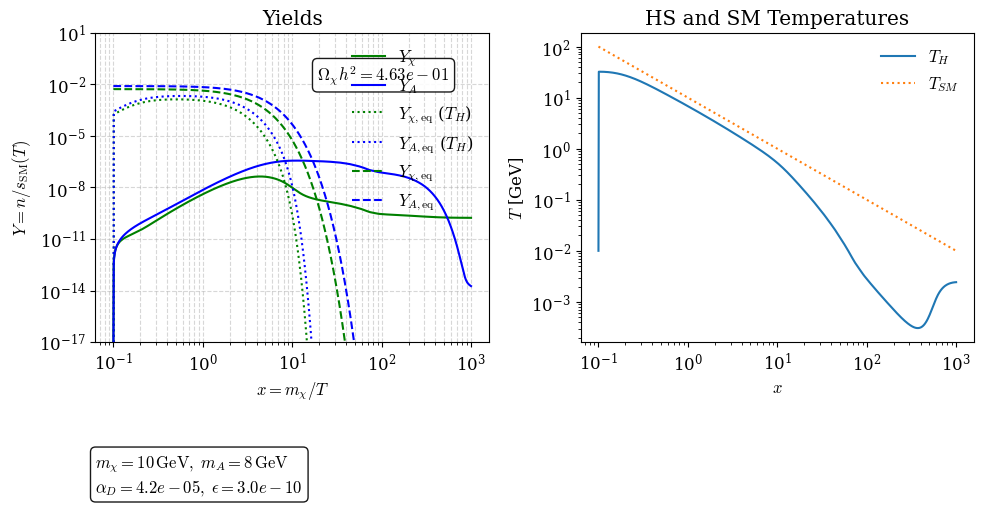

In [ ]:
# Diagnostics: yields vs SM entropy
mchi = params["mchi"]
xs = x_evolve


T = mchi/xs
Th = Th_evolve
Ychi = Y(nchi_evolve, T)
YA  = Y(nA_evolve, T)
Omega_h2 = get_relic_abundance(Ychi[-1], mchi)


nchi_eq_SM = neq_stable(mchi, gchi, T)     # eq at SM temp
nA_eq_SM   = neq_stable(mA,   gA,   T)
nchi_eq_HS = neq_stable(mchi, gchi, Th)    # eq at HS temp
nA_eq_HS   = neq_stable(mA,   gA,   Th)

# convert to yields using s_SM(T)
Ychi_eq_SM = Y(nchi_eq_SM, T)
YA_eq_SM   = Y(nA_eq_SM,   T)
Ychi_eq_HS = Y(nchi_eq_HS, T)
YA_eq_HS   = Y(nA_eq_HS,   T)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].loglog(xs, Ychi, color = "green", label=r'$Y_\chi$')
ax[0].loglog(xs, YA, color = "blue", label=r'$Y_{A}$')

# plot equilibrium yields for comparison
ax[0].loglog(xs, Ychi_eq_HS, ':',  color = "green", label=r'$Y_{\chi,{\rm eq}}$ ($T_H$)')
ax[0].loglog(xs, YA_eq_HS,  ':', color = "blue", label=r'$Y_{A,{\rm eq}}$ ($T_H$)')
ax[0].loglog(xs, Ychi_eq_SM, '--',  color = "green", label=r'$Y_{\chi,{\rm eq}}$ ')
ax[0].loglog(xs, YA_eq_SM,  '--', color = "blue", label=r'$Y_{A,{\rm eq}}$')

ax[0].set_ylim(1e-17, 1e1)

ax[0].set_xlabel(r'$x=m_\chi/T$'); ax[0].set_ylabel(r'$Y=n/s_{\rm SM}(T)$'); ax[0].legend(frameon=False)
ax[0].set_title('Yields')

# text annotation for model parameters
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
) % (params["mchi"], params["mA"],
     params["alphaD"], params["epsilon"])

param_text_ic = {
    r"$T_H = T$ at $x=%.1f$" % (x_i,),
    r"$n_\chi = %.1e$ at $x=%.1f$" % (nchi_i, x_i),
    r"$n_A = %.1e$ at $x=%.1f$" % (nA_i, x_i),
}
ax[0].text(
    0.0,-0.5, param_text,
    transform=ax[0].transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

# text annotation for relic abundance
relic_text = r"$\Omega_\chi h^2 = %.2e$" % (Omega_h2)
ax[0].text(
    0.9,0.9, relic_text,
    transform=ax[0].transAxes,
    va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)



## cosmetics
ax[0].grid(True, which='both', ls='--', alpha=0.5)
ax[1].loglog(xs, Th, label = r'$T_H$')
ax[1].loglog(xs, T, ':', label=r'$T_{SM}$')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$T$ [GeV]'); ax[1].legend(frameon=False)
ax[1].set_title('HS and SM Temperatures')



plt.tight_layout()
plt.show()

<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_16098/789882598.py:40: SyntaxWarning: invalid escape sequence '\c'
  plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2, label = "Sign change of $n_\chi / n_{\chi,eq}(T_h) - 1$")


(1e-07, 10000000.0)

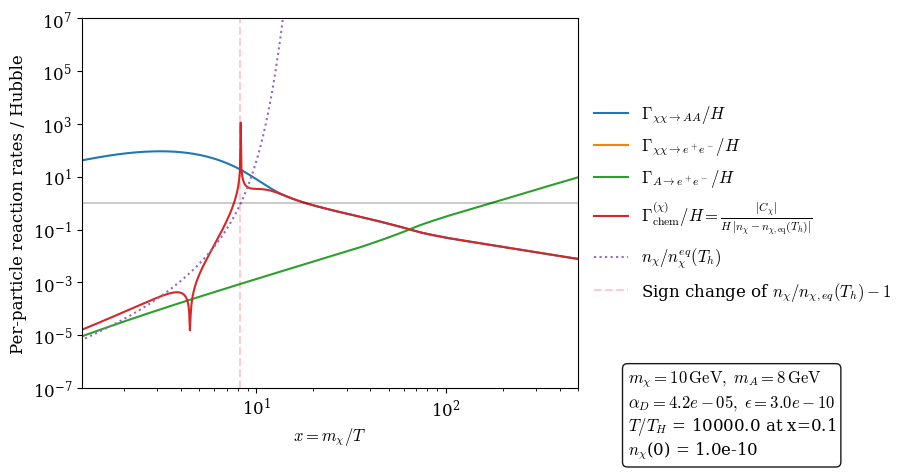

In [ ]:
# plot diagnostics
diag = result["diag"]
Gamma_xAA_over_H = diag["Gamma_xAA_over_H"]
Gamma_xSM_over_H = diag["Gamma_xSM_over_H"]
Gamma_Adec_over_H = diag["Gamma_Adec_over_H"]
gamma_chem_over_H = diag["Gamma_chem_over_H"]

label_chem = (r'$\Gamma_{\mathrm{chem}}^{(\chi)}/H'
         r' = \frac{|C_\chi|}{H\,|n_\chi - n_{\chi,\mathrm{eq}}(T_h)|}$')

nx_ratio = diag["nchi_over_nchieq"]
nA_ratio = diag["nA_over_nAeq"]
ratio_ratio = nx_ratio / nA_ratio
#PLOT
plt.figure()
plt.loglog(x_evolve, Gamma_xAA_over_H, label=r"$\Gamma_{\chi\chi \to AA} / H$")
plt.loglog(x_evolve, Gamma_xSM_over_H, label=r"$\Gamma_{\chi\chi \to e^+e^-} / H$")
plt.loglog(x_evolve, Gamma_Adec_over_H, label=r"$\Gamma_{A \to e^+e^-} / H$")
plt.loglog(x_evolve, gamma_chem_over_H, label= label_chem)

#plt.loglog(x_evolve, np.minimum(diag["dep_chi"], 1000000000), ls='--', label=r"$n_\chi / n_\chi^{eq}(T_h)$")

# cap_depchi = np.minimum(diag["dep_chi"], 1e50)
# print(cap_depchi)
# plt.plot(x_evolve, cap_depchi,   ls='--', label=r"$n_A / n_A^{eq}(T_h)$")
#plt.loglog(x_evolve, diag["dep_A"],   ls='--', label=r"$n_A / n_A^{eq}(T_h)$")

cap_nx_ratio = np.minimum(nx_ratio, 1e20)
cap_nA_ratio = np.minimum(nA_ratio, 1e20)

plt.loglog(x_evolve, cap_nx_ratio,   ls=':', label=r"$n_\chi / n_\chi^{eq}(T_h)$")
#plt.loglog(x_evolve, cap_nA_ratio,   ls='-.', label=r"$n_A / n_A^{eq}(T_h)$")
#plt.loglog(x_evolve, ratio_ratio,   ls=':', label=r"($n_\chi / n_\chi^{eq}(T_h)) \; / \; (n_A / n_A^{eq}(T_h)$)")


diffs = np.diff(np.sign(cap_nx_ratio - 1))
sign_changes = np.where(diffs != 0)[0]
for (i, idx) in enumerate(sign_changes):
    if i == 0:
        plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2, label = "Sign change of $n_\chi / n_{\chi,eq}(T_h) - 1$")
    else:
        plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2)


params = diag["params"]
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$" "\n"
    r"$T/T_H$ = %.1f at x=%.1f" "\n"
    r"$n_\chi$(0) = %.1e "
) % (params["mchi"], params["mA"],
     params["alphaD"], params["epsilon"],
     T_evolve[0]/Th_evolve[0], x_evolve[0],
        nchi_evolve[0]
        )

plt.text(1.1, -0.2, param_text,
            transform=plt.gca().transAxes,
            va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False)

plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=False, borderaxespad=0., handlelength=2, labelspacing=0.6)
plt.xlabel(r"$x = m_\chi / T$")
plt.ylabel(r"Per-particle reaction rates / Hubble")
plt.axhline(1.0, color='k', ls='-', alpha = 0.2)
plt.xlim(1.2, 500)
plt.ylim(1e-7, 1e7)

In [ ]:
#### "hierarchy" plots

In [4]:
alpha = 8e-5
epsilon =  3e-10
mchi = 10 # 0.3
mA = 8 # 0.3*0.7

gchi = 2
gA = 3

def make_params(mchi, mA, alphaD, eps, gchi = 2, gA = 3):
    return {
        "mchi": mchi, "mA": mA,
        "alphaD": alphaD, "epsilon": eps,
        "sv_xxAA": sigma_xx_to_AA(alphaD, mchi, mA),
        "sv_xxee": sigmav_chichi_ee(eps, alphaD, mchi, mA),
        "gamma_Aee": gammaA_ee(eps, mA),
        "t_dep": True, "gchi": gchi, "gA": gA,
    }

paramsA = make_params(mchi, mA, 8e-5, epsilon, gchi, gA)
paramsB = make_params(mchi, mA, 9e-5, epsilon, gchi, gA)
paramsC = make_params(mchi, mA, 10e-5, epsilon, gchi, gA)
paramsD = make_params(mchi, mA, 11e-5, epsilon, gchi, gA)


resultsA = evolve(paramsA, x_i, x_f, y0, xs, log_space = True)
resultsB = evolve(paramsB, x_i, x_f, y0, xs, log_space = True)
resultsC = evolve(paramsC, x_i, x_f, y0, xs, log_space = True)
resultsD = evolve(paramsD, x_i, x_f, y0, xs, log_space = True)

print("DONE")

omegah2A = get_relic_abundance(Y(np.exp(resultsA["sol"][0,-1]), mchi), mchi)
omegah2B = get_relic_abundance(Y(np.exp(resultsB["sol"][0,-1]), mchi), mchi)
omegah2C = get_relic_abundance(Y(np.exp(resultsC["sol"][0,-1]), mchi), mchi)
omegah2D = get_relic_abundance(Y(np.exp(resultsD["sol"][0,-1]), mchi), mchi)

DONE


In [5]:
for params_dict in [paramsA, paramsB, paramsC, paramsD]:
    print("alphaD: ", params_dict["alphaD"])
    print("sv_xxAA: ", params_dict["sv_xxAA"] * Gev2_to_cm3s)
    print("-----")

alphaD:  8e-05
sv_xxAA:  1.0963757127411906e-27
-----
alphaD:  9e-05
sv_xxAA:  1.3876005114380693e-27
-----
alphaD:  0.0001
sv_xxAA:  1.7130870511581105e-27
-----
alphaD:  0.00011
sv_xxAA:  2.072835331901314e-27
-----


/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_1410/2628061130.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False, fontsize=13, ncol=1)


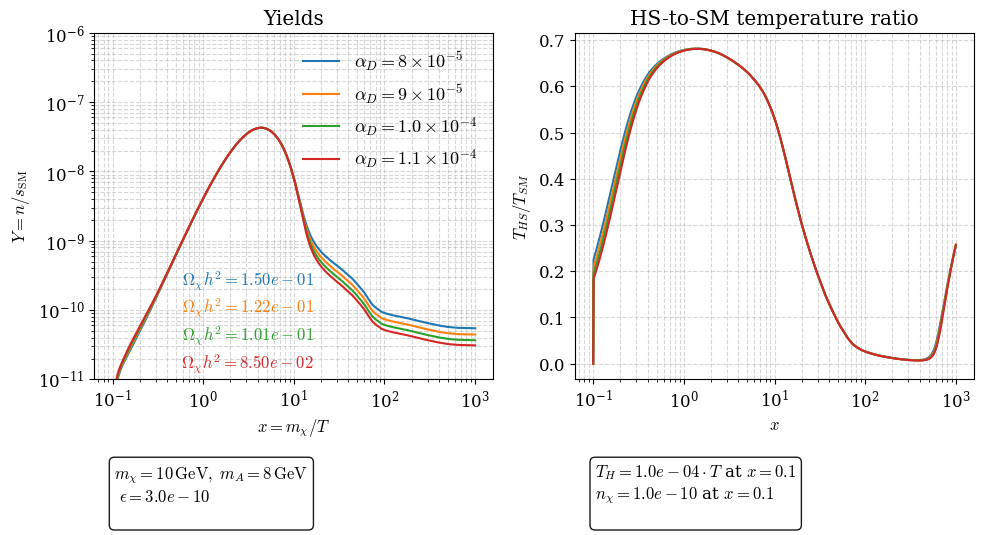

In [7]:
palette = plt.get_cmap('tab10')

runs = [
    {"params": paramsA, "result": resultsA,
     "label": r"$\alpha_D = 8\times10^{-5}$", "color": palette(0),   "Omega_h2": omegah2A},
    {"params": paramsB, "result": resultsB,
     "label": r"$\alpha_D = 9\times10^{-5}$", "color": palette(1),   "Omega_h2": omegah2B},
    {"params": paramsC, "result": resultsC,
     "label": r"$\alpha_D = 1.0\times10^{-4}$", "color": palette(2),  "Omega_h2": omegah2C},
    {"params": paramsD, "result": resultsD,
        "label": r"$\alpha_D = 1.1\times10^{-4}$", "color": palette(3),  "Omega_h2": omegah2D},
]

# --- CONFIG ---
ylims = (1e-11, 1e-6)
show_eq = True
show_param_box_first = True
show_relic_boxes = True

# --- STYLE ---
ls_cycle = cycle(['-', '--', '-.', ':'])
col_chi, col_A = "green", "blue"

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i, run in enumerate(runs):
    params = run["params"]
    mchi = float(params["mchi"])
    res = run["result"]
    nchi, nA, Th = res["sol"]
    x = res["x_arr"]
    T = mchi / x

    Ychi = Y(np.asarray(nchi), T)
    YA   = Y(np.asarray(nA),   T)

    lbl_run = run.get("label", f"run {i+1}")
    ls = next(ls_cycle)

    # --- Yields (per run) ---
    c = run.get("color", None)
    ax[0].loglog(xs, Ychi, color=c, label=rf"{lbl_run}", ls = "-")
    #ax[0].loglog(xs, YA,   ls=ls, color=col_A,  label=rf"$Y_A$ ({lbl_run})")

    # --- Equilibrium  ---
    if show_eq:
        gchi = params.get("gchi", None)
        gA   = params.get("gA",   None)
        Ychi_eq = Y(neq(params["mchi"], gchi, T), T)
        YA_eq   = Y(neq(params["mA"],   gA,   T), T)
        #ax[0].loglog(xs, Ychi_eq, ":",  alpha=0.6, ls = "--", color = 'grey', label = rf"$Y_{{\chi,eq}}$")
        #ax[0].loglog(xs, YA_eq,   ":", color=col_A,  alpha=0.6, label=rf"$Y_A$")

    # --- Per-run relic abundance box (optional) ---
    if show_relic_boxes and ("Omega_h2" in run):
        omegah2 = get_relic_abundance(Ychi[-1], mchi)
        relic_text = r"$\Omega_\chi h^2 = {:.2e}$".format(omegah2)
        y_anchor = 0.32 - 0.08*(i % 6)  # stagger to avoid overlap
        ax[0].text(
            0.55, y_anchor, relic_text,
            transform=ax[0].transAxes, va='top', ha='right', color = c,
            #bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

    # --- Temperature ratio ---
    ax[1].plot(xs, Th/T, ls="-", color=c)

    if i == 0 and show_param_box_first:
        param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r" $ \epsilon = %.1e$" "\n"
    #r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    #r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["mA"], params["epsilon"])
        ax[0].text(
            0.05, -0.42, param_text,
            transform=ax[0].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

        ic_param_text = (
    r"$T_H = %.1e \cdot T$ at $x=%.1f$" "\n"
    r"$n_\chi = %.1e$ at $x=%.1f$" "\n"
    ) % (Th[0]/T[0], x[0], nchi[0], x[0])
        ax[1].text(
            0.05, -0.42, ic_param_text,
            transform=ax[1].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

# --- Cosmetics ---
ax[0].set_ylim(*ylims)
ax[0].set_xlabel(r"$x = m_\chi/T$")
ax[0].set_ylabel(r"$Y = n/s_{\rm SM}$")
ax[0].set_title("Yields")
ax[0].grid(True, which='both', ls='--', alpha=0.5)

ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$T_{HS}/T_{SM}$")
ax[1].set_title("HS-to-SM temperature ratio")
ax[1].grid(True, which='both', ls='--', alpha=0.5)

ax[0].legend(frameon=False, fontsize=13, ncol=1)
ax[1].legend(frameon=False, fontsize=13, ncol=1)
ax[1].set_xscale('log')


plt.tight_layout()
plt.show()


<>:35: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\c'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_16098/904882130.py:35: SyntaxWarning: invalid escape sequence '\c'
  plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2, label = "Sign change of $n_\chi / n_{\chi,eq}(T_h) - 1$")


(1e-17, 1e+17)

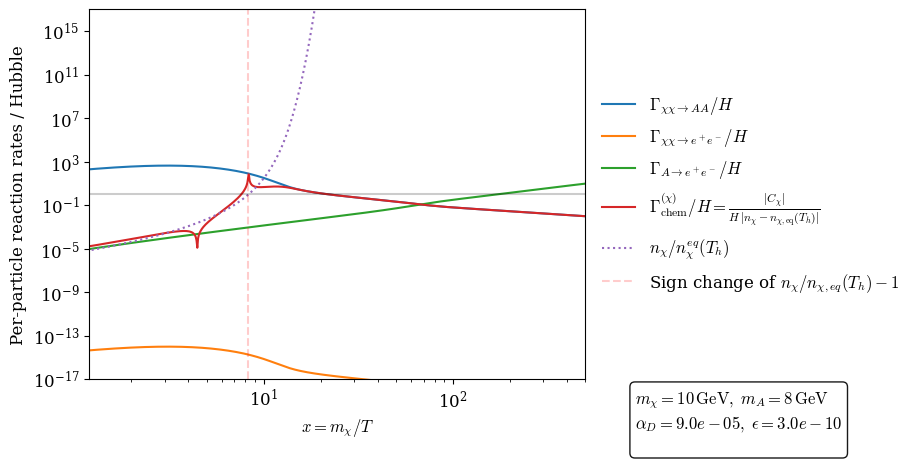

In [151]:
## diagnostics for best run

# plot diagnostics
diag = resultsB["diag"]
Gamma_xAA_over_H = diag["Gamma_xAA_over_H"]
Gamma_xSM_over_H = diag["Gamma_xSM_over_H"]
Gamma_Adec_over_H = diag["Gamma_Adec_over_H"]
gamma_chem_over_H = diag["Gamma_chem_over_H"]

label_chem = (r'$\Gamma_{\mathrm{chem}}^{(\chi)}/H'
         r' = \frac{|C_\chi|}{H\,|n_\chi - n_{\chi,\mathrm{eq}}(T_h)|}$')

nx_ratio = diag["nchi_over_nchieq"]
nA_ratio = diag["nA_over_nAeq"]
ratio_ratio = nx_ratio / nA_ratio
#PLOT
plt.figure()
plt.loglog(x_evolve, Gamma_xAA_over_H, label=r"$\Gamma_{\chi\chi \to AA} / H$")
plt.loglog(x_evolve, Gamma_xSM_over_H, label=r"$\Gamma_{\chi\chi \to e^+e^-} / H$")
plt.loglog(x_evolve, Gamma_Adec_over_H, label=r"$\Gamma_{A \to e^+e^-} / H$")
plt.loglog(x_evolve, gamma_chem_over_H, label= label_chem)

cap_nx_ratio = np.minimum(nx_ratio, 1e20)
cap_nA_ratio = np.minimum(nA_ratio, 1e20)

plt.loglog(x_evolve, cap_nx_ratio,   ls=':', label=r"$n_\chi / n_\chi^{eq}(T_h)$")
#plt.loglog(x_evolve, cap_nA_ratio,   ls='-.', label=r"$n_A / n_A^{eq}(T_h)$")
#plt.loglog(x_evolve, ratio_ratio,   ls=':', label=r"($n_\chi / n_\chi^{eq}(T_h)) \; / \; (n_A / n_A^{eq}(T_h)$)")


diffs = np.diff(np.sign(cap_nx_ratio - 1))
sign_changes = np.where(diffs != 0)[0]
for (i, idx) in enumerate(sign_changes):
    if i == 0:
        plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2, label = "Sign change of $n_\chi / n_{\chi,eq}(T_h) - 1$")
    else:
        plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2)


params = diag["params"]
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$" "\n"
    # r"$T/T_H$ = %.1f at x=%.1f" "\n"
    # r"$n_\chi$(0) = %.1e "
) % (params["mchi"], params["mA"],
     params["alphaD"], params["epsilon"])
    #  T_evolve[0]/Th_evolve[0], x_evolve[0],
    #     nchi_evolve[0]
    #     )

plt.text(1.1, -0.2, param_text,
            transform=plt.gca().transAxes,
            va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False)

plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=False, borderaxespad=0., handlelength=2, labelspacing=0.6)
plt.xlabel(r"$x = m_\chi / T$")
plt.ylabel(r"Per-particle reaction rates / Hubble")
plt.axhline(1.0, color='k', ls='-', alpha = 0.2)
plt.xlim(1.2, 500)
plt.ylim(1e-17, 1e17)

In [8]:
# now, let's check that for this best value, there is minimal sensitivity to epsilon
alpha = 9e-5
epsilon =  1.5e-10
mchi = 10 # 0.3
mA = 8 # 0.3*0.7

gchi = 2
gA = 3
paramsAe = make_params(mchi, mA, alpha, epsilon, gchi, gA)
paramsBe = make_params(mchi, mA, alpha, epsilon *2, gchi, gA)
paramsCe = make_params(mchi, mA, alpha, epsilon *4, gchi, gA)
paramsDe = make_params(mchi, mA, alpha, epsilon *8, gchi, gA)


x_i, x_f = 0.1, 1000.0
T_i = mchi / x_i
Th_i = 1e-4* T_i  # start very cold
nchi_i = 1e-10
nA_i  = 1e-10
y0 = np.array([nchi_i, nA_i, Th_i])
xs  = np.geomspace(x_i, x_f, 1000)

resultsAe = evolve(paramsAe, x_i, x_f, y0, xs, log_space = True)
resultsBe = evolve(paramsBe, x_i, x_f, y0, xs, log_space = True)
resultsCe = evolve(paramsCe, x_i, x_f, y0, xs, log_space = True)
resultsDe = evolve(paramsDe, x_i, x_f, y0, xs, log_space = True)

print("DONE")


DONE


/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_1410/484062362.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False, fontsize=13, ncol=1)


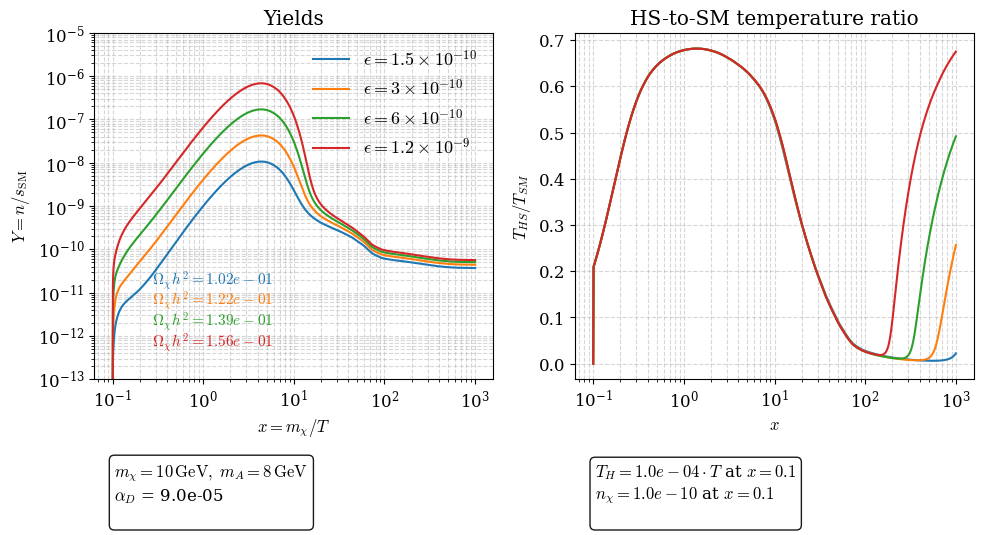

In [9]:
palette = plt.get_cmap('tab10')

runs = [
    {"params": paramsAe, "result": resultsAe,
     "label": r"$\epsilon = 1.5\times10^{-10}$", "color": palette(0)},
    {"params": paramsBe, "result": resultsBe,
     "label": r"$\epsilon = 3\times10^{-10}$", "color": palette(1)},
    {"params": paramsCe, "result": resultsCe,
     "label": r"$\epsilon = 6\times10^{-10}$", "color": palette(2)},
    {"params": paramsDe, "result": resultsDe,
        "label": r"$\epsilon = 1.2\times10^{-9}$", "color": palette(3)},
]

# --- CONFIG ---
ylims = (1e-13, 1e-5)
show_eq = True
show_param_box_first = True
show_relic_boxes = True

# --- STYLE ---
ls_cycle = cycle(['-', '--', '-.', ':'])
col_chi, col_A = "green", "blue"

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i, run in enumerate(runs):
    params = run["params"]
    mchi = float(params["mchi"])
    res = run["result"]
    nchi, nA, Th = res["sol"]
    x = res["x_arr"]
    T = mchi / x

    Ychi = Y(np.asarray(nchi), T)
    YA   = Y(np.asarray(nA),   T)

    lbl_run = run.get("label", f"run {i+1}")
    ls = next(ls_cycle)

    # --- Yields (per run) ---
    c = run.get("color", None)
    ax[0].loglog(xs, Ychi, color=c, label=rf"{lbl_run}", ls = "-")
    #ax[0].loglog(xs, YA,   ls=ls, color=col_A,  label=rf"$Y_A$ ({lbl_run})")

    if show_eq:
        gchi = params.get("gchi", None)
        gA   = params.get("gA",   None)
        Ychi_eq = Y(neq(params["mchi"], gchi, T), T)
        YA_eq   = Y(neq(params["mA"],   gA,   T), T)
        #ax[0].loglog(xs, Ychi_eq, ":",  alpha=0.6, ls = "--", color = 'grey', label = rf"$Y_{{\chi,eq}}$")
        #ax[0].loglog(xs, YA_eq,   ":", color=col_A,  alpha=0.6, label=rf"$Y_A$")

    if show_relic_boxes:
        omegah2 = get_relic_abundance(Ychi[-1], mchi)
        relic_text = r"$\Omega_\chi h^2 = {:.2e}$".format(omegah2)
        y_anchor = 0.32 - 0.06*(i % 6)  # stagger to avoid overlap
        ax[0].text(
            0.45, y_anchor, relic_text,
            transform=ax[0].transAxes, va='top', ha='right', color = c,
            #bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False, fontsize = 11
        )

    # --- Temperature ratio ---
    ax[1].plot(xs, Th/T, ls="-", color=c)

    if i == 0 and show_param_box_first:
        param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    #r" $ \epsilon = %.1e$" "\n"
    r"$\alpha_D$ = %.1e" "\n"
    #r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    #r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["mA"], params["alphaD"])
        ax[0].text(
            0.05, -0.42, param_text,
            transform=ax[0].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

        ic_param_text = (
    r"$T_H = %.1e \cdot T$ at $x=%.1f$" "\n"
    r"$n_\chi = %.1e$ at $x=%.1f$" "\n"
    ) % (Th[0]/T[0], x[0], nchi[0], x[0])
        ax[1].text(
            0.05, -0.42, ic_param_text,
            transform=ax[1].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

# --- Cosmetics ---
ax[0].set_ylim(*ylims)
ax[0].set_xlabel(r"$x = m_\chi/T$")
ax[0].set_ylabel(r"$Y = n/s_{\rm SM}$")
ax[0].set_title("Yields")
ax[0].grid(True, which='both', ls='--', alpha=0.5)

ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$T_{HS}/T_{SM}$")
ax[1].set_title("HS-to-SM temperature ratio")
ax[1].grid(True, which='both', ls='--', alpha=0.5)

ax[0].legend(frameon=False, fontsize=13, ncol=1)
ax[1].legend(frameon=False, fontsize=13, ncol=1)
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()


In [ ]:
# we want to check the sensitivity now to x_i
# scan over xi in [0.01, 0.1, 0.5, 1.0]

#xis = [1.0, 5.0, 20.]
alpha = 9e-5
epsilon =  3e-10
mchi = 10 # 0.3
mA = 8 # 0.3*0.7
paramsA =make_params(mchi, mA, alpha, epsilon)
print(paramsA["sv_xxAA"] * Gev2_to_cm3s)

x_f = 1000.0

xis = [0.01, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0]
results =  []
for x_i in xis:
    T_i = mchi / x_i

    Th_i = 1e-4* T_i  # start very cold
    nchi_i = 1e-10
    nA_i  = 1e-10
    y0 = np.array([nchi_i, nA_i, Th_i])  # initial conditions: n_chi, n_A, Th, H, C_chi, C_A
    xs  = np.geomspace(x_i, x_f, 1000)

    start = time.time()
    result = evolve(paramsA, x_i, x_f, y0, xs, log_space = True)
    end = time.time()
    results.append(result)
    print("Time taken: ", end - start, " seconds")

1.3876005114380693e-27
Time taken:  35.6953809261322  seconds
Time taken:  22.840534925460815  seconds
Time taken:  22.130946159362793  seconds
Time taken:  22.963721990585327  seconds
Time taken:  21.58773112297058  seconds
Time taken:  18.902459859848022  seconds
Time taken:  11.188014030456543  seconds


0.01
0.1
0.25
0.5
1.0
2.0
5.0


Text(0, 0.5, '$\\Omega_\\chi h^2$')

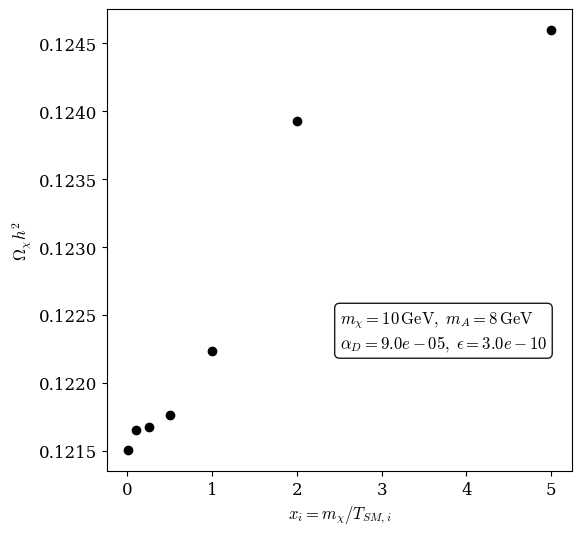

In [ ]:
yields = []
abundances = []
for res in results:
    nchi_evolve, nA_evolve, Th_evolve = res["sol"]
    x_evolve = res["x_arr"]
    print(x_evolve[0])
    T_evolve = mchi / x_evolve
    Ychi = Y(nchi_evolve, T_evolve)
    Omega_h2 = get_relic_abundance(Ychi[-1], mchi)
    yields.append(Ychi)
    omegah2 = get_relic_abundance(Ychi[-1], mchi)
    abundances.append(omegah2)

palette = plt.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(xis, abundances, color='black', label = xis)

param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
) % (paramsA["mchi"], paramsA["mA"],
     paramsA["alphaD"], paramsA["epsilon"])
ax.text(
    0.5, 0.35, param_text,
    transform=ax.transAxes,
    va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

plt.xlabel(r"$x_i = m_\chi / T_{SM,i}$")
plt.ylabel(r"$\Omega_\chi h^2$")
# for i, xi in enumerate(xis):
#     Ychi = yields[i]
#     c = palette(i)
#     ax.loglog(xs, Ychi, color=c, label=rf"$\xi = {xi}$", ls = "-")


In [10]:

alpha = 9e-5
epsilon =  3e-10
mchi = 10 # 0.3
mA = 8 # 0.3*0.7

gchi = 2
gA = 3
paramsA = {
    "mchi": mchi,
    "mA":   mA,
    "alphaD": alpha,
    "epsilon": epsilon,
    "sv_xxee": sigmav_chichi_ee(epsilon, alpha, mchi, mA),
    "sv_xxAA": sigma_xx_to_AA(alpha, mchi, mA),
    "t_dep": True,
    "gamma_Aee": gamma,
    "gchi": gchi,
    "gA": gA}
print(paramsA["sv_xxAA"] * Gev2_to_cm3s)

x_i = 0.1
x_f = 1000.0

T_ratios = [1e-4, 1e-3, 1e-2, 0.1, 0.2, 1.0]
resultsT =  []

for T_ratio in T_ratios:
    T_i = mchi / x_i

    Th_i = T_i * T_ratio  # start very cold
    nchi_i = 1e-10
    nA_i  = 1e-10
    y0 = np.array([nchi_i, nA_i, Th_i])  # initial conditions: n_chi, n_A, Th, H, C_chi, C_A
    xs  = np.geomspace(x_i, x_f, 1000)

    start = time.time()
    result = evolve(paramsA, x_i, x_f, y0, xs, log_space = True)
    end = time.time()
    resultsT.append(result)
    print("Time taken: ", end - start, " seconds")

1.3876005114380693e-27
Time taken:  23.161078691482544  seconds
Time taken:  23.109739065170288  seconds
Time taken:  22.937855005264282  seconds
Time taken:  20.564546823501587  seconds
Time taken:  23.33025598526001  seconds
Time taken:  22.00587010383606  seconds


0.1
0.1
0.1
0.1
0.1
0.1
[np.float64(0.12165553809360873), np.float64(0.12165673166408464), np.float64(0.12165726473190872), np.float64(0.1216556251113797), np.float64(0.12165642224416956), np.float64(0.12165655855419387)]


Text(0, 0.5, '$\\Delta(\\Omega_\\chi h^2$) relative to $T_H = 10^{-4} T$')

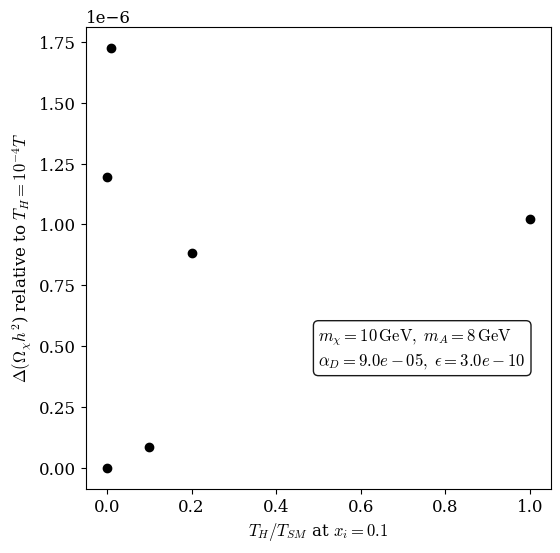

In [11]:
yields = []
abundances = []
for res in resultsT:
    nchi_evolve, nA_evolve, Th_evolve = res["sol"]
    x_evolve = res["x_arr"]
    print(x_evolve[0])
    T_evolve = mchi / x_evolve
    Ychi = Y(nchi_evolve, T_evolve)
    Omega_h2 = get_relic_abundance(Ychi[-1], mchi)
    yields.append(Ychi)
    omegah2 = get_relic_abundance(Ychi[-1], mchi)
    abundances.append(omegah2)

print(abundances)

abundances_sub = [a - abundances[0] for a in abundances]
palette = plt.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#ax.scatter(xis, abundances_sub, color='black', label = xis)
ax.scatter(T_ratios, abundances_sub, color='black', label = T_ratios)


param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
) % (paramsA["mchi"], paramsA["mA"],
     paramsA["alphaD"], paramsA["epsilon"])
ax.text(
    0.5, 0.35, param_text,
    transform=ax.transAxes,
    va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

plt.xlabel(r"$T_H / T_{SM}$ at $x_i = 0.1$")
plt.ylabel(r"$\Delta(\Omega_\chi h^2$) relative to $T_H = 10^{-4} T$")


# for i, T_rat in enumerate(T_ratios):
#     Ychi = yields[i]
#     c = palette(i)
#     ax.loglog(xs, Ychi, color=c, label=rf"$T_H/T = {T_rat}$", ls = "-")
